# Drake Passsage Transport

<i>From Stephen Griffies -- CM4X Development<br>https://github.com/StephenGriffies/CM4X</i>

### MAR Configuration

In [1]:
import os
import datetime
import doralite

config = {
    "startyr": "1958",
    "endyr": "2022",
    "dora_id": "odiv-319",
    "pathPP": "/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/"
    + "om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/",
}

for k, v in config.items():
    config[k] = (
        os.environ[f"MAR_{k.upper()}"]
        if f"MAR_{k.upper()}" in os.environ.keys()
        else v
    )

In [2]:
# Define some local variables. These are taken from the doralite object
# or they can be defined locally

experiment =  doralite.dora_metadata(config["dora_id"])
pathPP = experiment["pathPP"]
expName = experiment["expName"]

# Define start and end years
start = int(config["startyr"])
end = int(config["endyr"])

### Import Modules

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import doralite
import glob
import subprocess
import momlevel

from datetime import timedelta

print("numpy version  : ", np.__version__)
print("pandas version : ", pd.__version__)
print("xarray version : ", xr.__version__)

numpy version  :  1.23.5
pandas version :  2.1.1
xarray version :  2023.10.1


### Load Files

In [4]:
# Determine what files are needed (leave this up to the developer for flexibility)
# This is an example of what someone might do:

component = "ocean_Drake_Passage"
static = f"{component}/{component}.static.nc"
varname = "umo"

chunk = "5yr"
filelist = sorted(glob.glob(f"{pathPP}{component}/ts/monthly/{chunk}/{component}.*.{varname}.nc"))

def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

filelist = [x for x in filelist if is_in_range(x,start,end)]
staticfile = f"{pathPP}/{static}"

_ = [print(x) for x in filelist]

/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_Drake_Passage/ts/monthly/5yr/ocean_Drake_Passage.195801-196212.umo.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_Drake_Passage/ts/monthly/5yr/ocean_Drake_Passage.196301-196712.umo.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_Drake_Passage/ts/monthly/5yr/ocean_Drake_Passage.196801-197212.umo.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_Drake_Passage/ts/monthly/5yr/ocean_Drake_Passage.197301-197712.umo.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_Drake_Passage/ts/monthly/5yr/ocean_Drake_Passage.197801-198212.umo.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om

In [5]:
if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"]+filelist+[staticfile]
    _ = subprocess.check_output(cmd)

Calling dmget on files ...


### Calculations and Plots from CM4X Notebook

In [6]:
# Open dataset
ds = xr.open_mfdataset(filelist, use_cftime=True)

# Sum transport and convert to Sv
umo = ds['umo'].sum(dim=['yh_sub01','z_l'])/1e9

# Drop singleton dimension
umo = umo.squeeze()

# Compute the time mean, taking into account the number of days in a month
# (momlevel utility appropriately handles gregorian and noleap calendars)
umo = momlevel.util.annual_average(umo)

Text(0.5, 1.0, 'Drake Passage mass transport (Sv)')

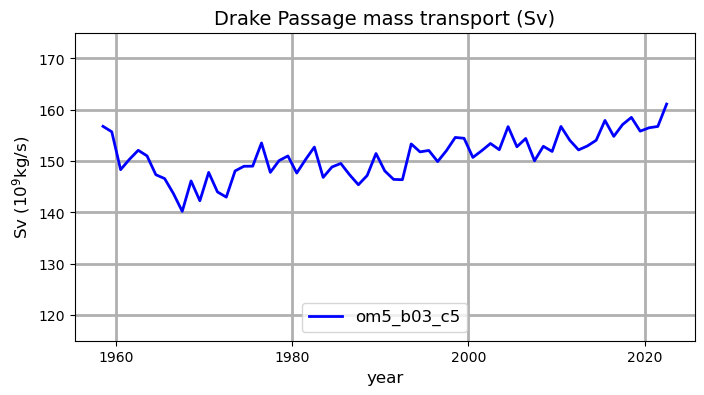

In [7]:
fig, axis = plt.subplots(ncols=1, nrows=1, figsize=(8,4), dpi=100)

umo.plot.line(ax=axis, label=expName,linestyle='solid', color='blue', linewidth=2) 

axis.legend(loc='lower center',fontsize=12)
axis.set_ylim([115,175])
axis.set_ylabel('Sv ($10^{9}$kg/s)', fontsize=12)
axis.set_xlabel('year', fontsize=12)
axis.grid(linewidth=2)

axis.set_title('Drake Passage mass transport (Sv)', fontsize=14)